<a href="https://colab.research.google.com/github/14gabe14/neural-correlations/blob/main/cross_correlation_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Stringer spontaneous data

includes some visualizations

In [ ]:
# @title Install dependencies
!pip install umap-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 789.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details.
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other.
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [ ]:
print(dat['sresp'].shape)
print(len(dat['stat']))
print(dat['run'].shape)
print(dat['pupilArea'].shape)

(11983, 7018)
11983
(7018, 1)
(7018, 1)


<ipython-input-7-749e88150ef0>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


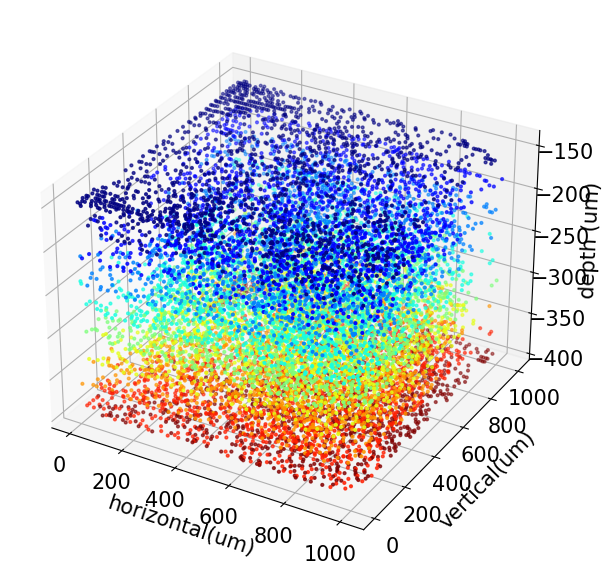

In [ ]:
# @title Plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

In [ ]:
sresp_data = dat['sresp']
run_data = dat['run']

In [ ]:
def calculate_cross_correlation(sresp_data, data):
    num_neurons, time_bins = sresp_data.shape
    cross_corr_results = np.empty((num_neurons, 201))

    for neuron_idx in range(num_neurons):
        cross_corr_results[neuron_idx] = np.correlate(data, sresp_data[neuron_idx, 100:-100], mode='valid')

    return cross_corr_results

In [ ]:
# @title Running Speed Cross Correlation
# Running the cross-correlation
cross_correlation_results = calculate_cross_correlation(dat['sresp'], dat['run'][:, 0])

In [ ]:
# Calculate mean and standard deviation for each neuron's cross-correlation
mean_cross_corr = np.mean(cross_correlation_results, axis=1)
std_cross_corr = np.std(cross_correlation_results, axis=1)

# Find the argmax (time lag with highest correlation value) for each neuron
argmax_cross_corr = np.argmax(cross_correlation_results, axis=1)
max_cross_corr = np.max(cross_correlation_results, axis=1)

In [ ]:
argmax_cross_corr_bef = np.argmax(cross_correlation_results[:, :101], axis=1)
max_cross_corr_bef = np.max(cross_correlation_results[:, :101], axis=1)

# Calculate mean and standard deviation for each neuron's cross-correlation
mean_cross_corr_bef = np.mean(cross_correlation_results[:, :101], axis=1)
std_cross_corr_bef = np.std(cross_correlation_results[:, :101], axis=1)

In [ ]:
# Calculate the number of argmax values that surpass the mean by at least one standard deviation
num_surpass_mean_std = np.sum(max_cross_corr > mean_cross_corr + std_cross_corr)
print(num_surpass_mean_std)

11983


In [ ]:
# Calculate the number of argmax values that surpass the mean by at least one standard deviation
num_surpass_mean_std = np.sum(max_cross_corr > mean_cross_corr + std_cross_corr * 2)
print(num_surpass_mean_std)

9871


In [ ]:
correlated_neurons_run = max_cross_corr > (mean_cross_corr + 4 * std_cross_corr)

In [ ]:
# @title Cross Correlation Pupil Area

cross_correlation_results_pa = calculate_cross_correlation(dat['sresp'], dat['pupilArea'][:, 0])

# Calculate mean and standard deviation for each neuron's cross-correlation
mean_cross_corr_pa = np.mean(cross_correlation_results_pa, axis=1)
std_cross_corr_pa = np.std(cross_correlation_results_pa, axis=1)

# Find the argmax (time lag with highest correlation value) for each neuron
argmax_cross_corr_pa = np.argmax(cross_correlation_results_pa, axis=1)
max_cross_corr_pa = np.max(cross_correlation_results_pa, axis=1)

correlated_neurons_pa = max_cross_corr_pa > (mean_cross_corr_pa + 3.8 * std_cross_corr_pa)
print(len(correlated_neurons_pa))

11983


In [ ]:
# @title Cross Correlation Pupil COM

Z = np.nan_to_num(dat['pupilCOM'])
pca = PCA(n_components=1)
X = pca.fit_transform(Z)

print(pca.explained_variance_ratio_)
print(X.shape)

[0.89306586]
(7018, 1)


In [ ]:
# Running the cross-correlation
cross_correlation_results_pcom = calculate_cross_correlation(dat['sresp'], X[:, 0])

# Calculate mean and standard deviation for each neuron's cross-correlation
mean_cross_corr_pcom = np.mean(cross_correlation_results_pcom, axis=1)
std_cross_corr_pcom = np.std(cross_correlation_results_pcom, axis=1)

# Find the argmax (time lag with highest correlation value) for each neuron
argmax_cross_corr_pcom = np.argmax(cross_correlation_results_pcom, axis=1)
max_cross_corr_pcom = np.max(cross_correlation_results_pcom, axis=1)

correlated_neurons_pcom = max_cross_corr_pcom > (mean_cross_corr_pcom + 4 * std_cross_corr_pcom)

In [ ]:
# @title Cross Correlation for Acceleration

dat['acceleration'] = np.diff(dat['run'], axis=0)/1.2
dat['acceleration'] = np.insert(dat['acceleration'], 0, 0, axis=0)

# Running the cross-correlation
cross_correlation_results_acc = calculate_cross_correlation(dat['sresp'], dat['acceleration'][:, 0])

# Calculate mean and standard deviation for each neuron's cross-correlation
mean_cross_corr_acc = np.mean(cross_correlation_results_acc, axis=1)
std_cross_corr_acc = np.std(cross_correlation_results_acc, axis=1)

# Find the argmax (time lag with highest correlation value) for each neuron
argmax_cross_corr_acc = np.argmax(cross_correlation_results_acc, axis=1)
max_cross_corr_acc = np.max(cross_correlation_results_acc, axis=1)

correlated_neurons_acc = max_cross_corr_acc > (mean_cross_corr_acc + 4 * std_cross_corr_acc)

In [ ]:
from matplotlib_venn import venn3

def get_venn_labels(arr1, arr2, arr3):
    # Convert boolean arrays to sets of indices where True
    set1 = set(i for i, val in enumerate(arr1) if val)
    set2 = set(i for i, val in enumerate(arr2) if val)
    set3 = set(i for i, val in enumerate(arr3) if val)

    # Compute the set intersections and differences
    intersection_12 = set1 & set2
    intersection_23 = set2 & set3
    intersection_13 = set1 & set3
    intersection_123 = set1 & set2 & set3

    return (
        len(set1 - (intersection_12 | intersection_13 | intersection_123)),  # Only in set1
        len(set2 - (intersection_12 | intersection_23 | intersection_123)),  # Only in set2
        len(intersection_12 - intersection_123),  # In set1 and set2, not in set3
        len(set3 - (intersection_23 | intersection_13 | intersection_123)),  # Only in set3
        len(intersection_13 - intersection_123),  # In set1 and set3, not in set2
        len(intersection_23 - intersection_123),  # In set2 and set3, not in set1
        len(intersection_123)  # In set1, set2 and set3
    )

(686, 159, 398, 705, 4, 46, 4)


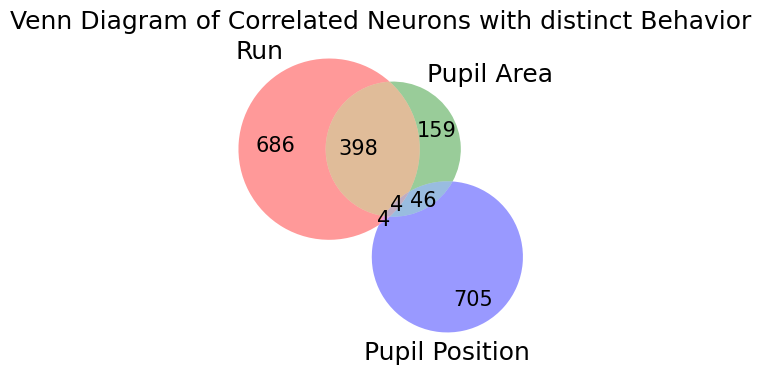

In [ ]:
# Get the Venn diagram counts
counts = get_venn_labels(correlated_neurons_run, correlated_neurons_pa, correlated_neurons_pcom)
print(counts)

# Create the Venn diagram
venn = venn3(subsets=counts, set_labels=('Run', 'Pupil Area', 'Pupil Position'))

# Show the diagram
plt.title("Venn Diagram of Correlated Neurons with distinct Behavior")
plt.show()

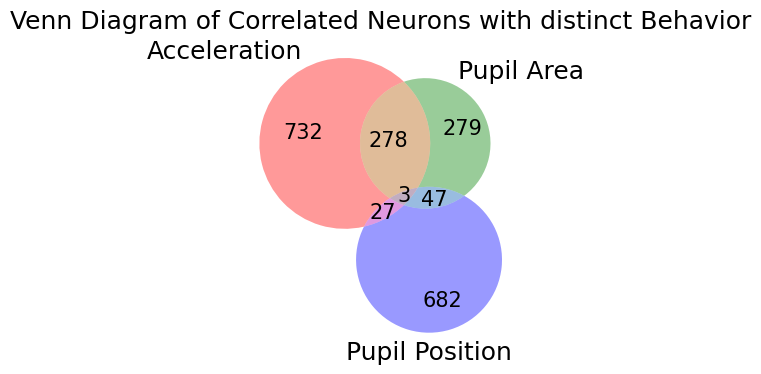

In [ ]:
# Get the Venn diagram counts
counts = get_venn_labels(correlated_neurons_acc, correlated_neurons_pa, correlated_neurons_pcom)

# Create the Venn diagram
venn = venn3(subsets=counts, set_labels=('Acceleration', 'Pupil Area', 'Pupil Position'))

# Show the diagram
plt.title("Venn Diagram of Correlated Neurons with distinct Behavior")
plt.show()

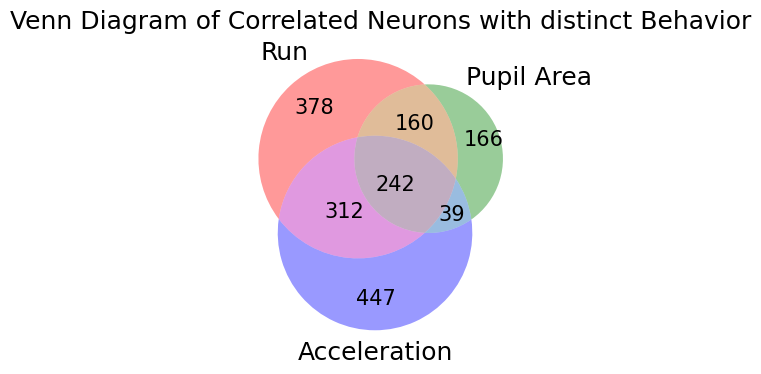

In [ ]:
# Get the Venn diagram counts
counts = get_venn_labels(correlated_neurons_run, correlated_neurons_pa, correlated_neurons_acc)

# Create the Venn diagram
venn = venn3(subsets=counts, set_labels=('Run', 'Pupil Area', 'Acceleration'))

# Show the diagram
plt.title("Venn Diagram of Correlated Neurons with distinct Behavior")
plt.show()

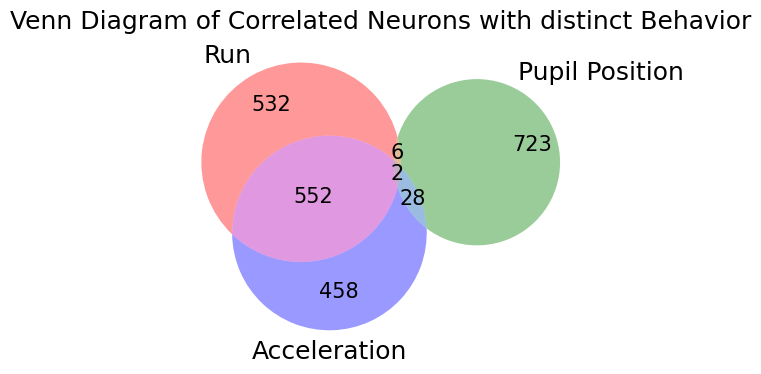

In [ ]:
# Get the Venn diagram counts
counts = get_venn_labels(correlated_neurons_run, correlated_neurons_pcom, correlated_neurons_acc)

# Create the Venn diagram
venn = venn3(subsets=counts, set_labels=('Run', 'Pupil Position', 'Acceleration'))

# Show the diagram
plt.title("Venn Diagram of Correlated Neurons with distinct Behavior")
plt.show()

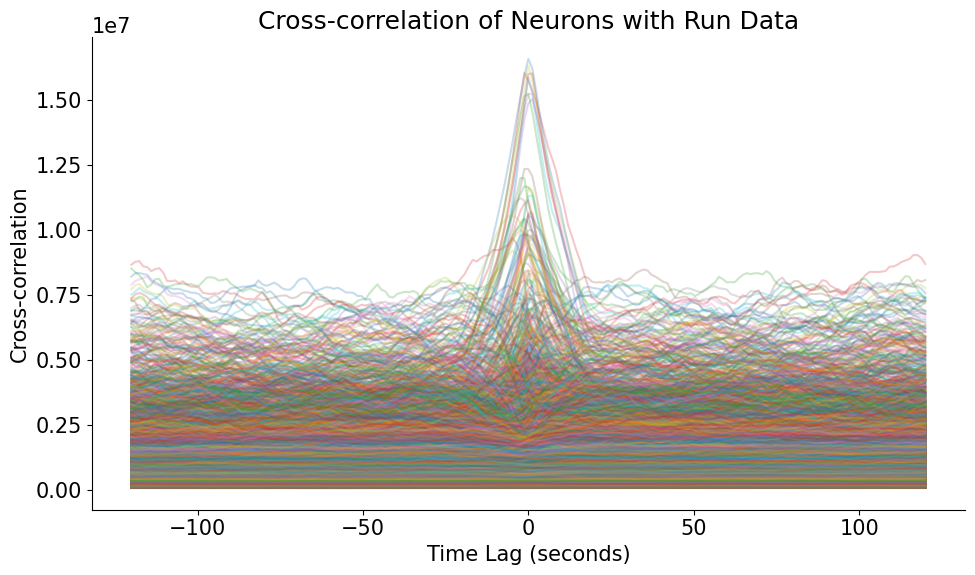

Argmax for each neuron (time lag with highest correlation):
[101 112 152 ... 154 145 182]


In [ ]:
# @title Cross Correlation of Neurons with Run Data
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each cross-correlation curve stacked vertically
neuron_indices = range(cross_correlation_results.shape[0])
time_bins = np.arange(-100, 101) * 1.2  # Assuming 1.2 sec per timebin

for neuron_idx in neuron_indices:
    ax.plot(time_bins, cross_correlation_results[neuron_idx], alpha=0.25)

# Set labels and title
ax.set_xlabel('Time Lag (seconds)')
ax.set_ylabel('Cross-correlation')
ax.set_title('Cross-correlation of Neurons with Run Data')

# Show the plot
plt.show()

# Print argmax for each neuron
print("Argmax for each neuron (time lag with highest correlation):")
print(argmax_cross_corr)

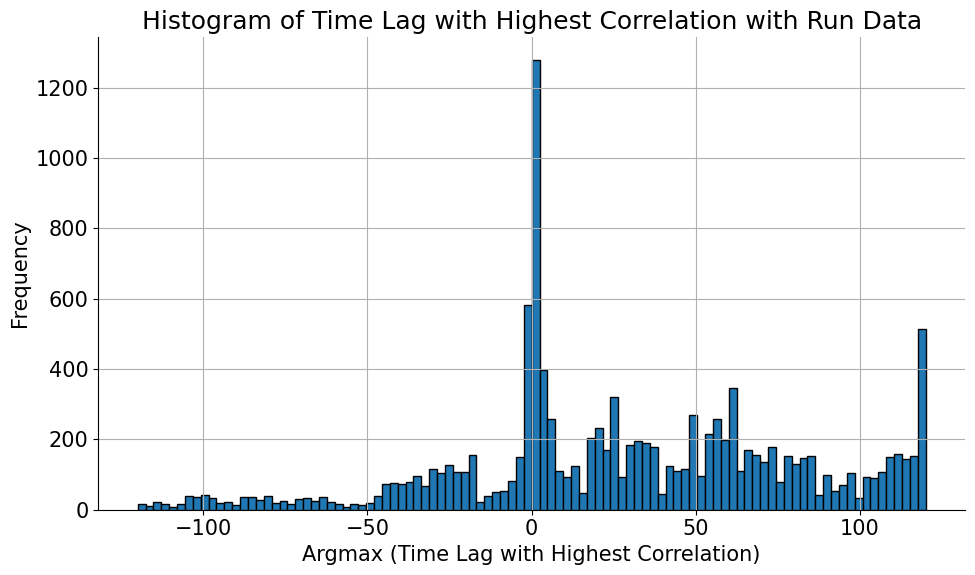

In [ ]:
# @title Histogram of Time Lag with Highest Correlation
# Create a histogram of argmax values
plt.figure(figsize=(10, 6))
plt.hist((argmax_cross_corr-100)*1.2, bins=100, edgecolor='black')
plt.xlabel('Argmax (Time Lag with Highest Correlation)')
plt.ylabel('Frequency')
plt.title('Histogram of Time Lag with Highest Correlation with Run Data')
plt.grid(True)
plt.show()

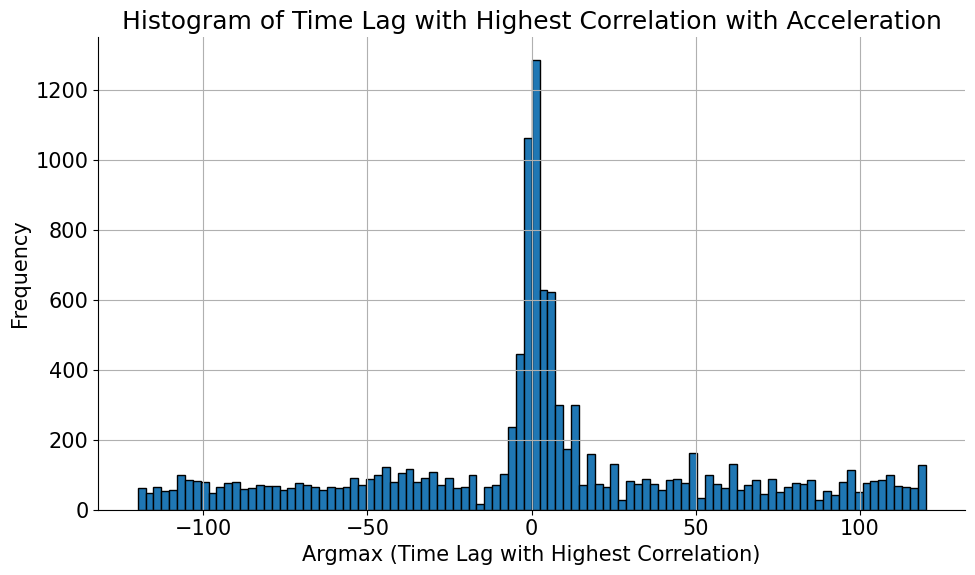

In [ ]:
# Create a histogram of argmax values
plt.figure(figsize=(10, 6))
plt.hist((argmax_cross_corr_acc-100)*1.2, bins=100, edgecolor='black')
plt.xlabel('Argmax (Time Lag with Highest Correlation)')
plt.ylabel('Frequency')
plt.title('Histogram of Time Lag with Highest Correlation with Acceleration')
plt.grid(True)
plt.show()

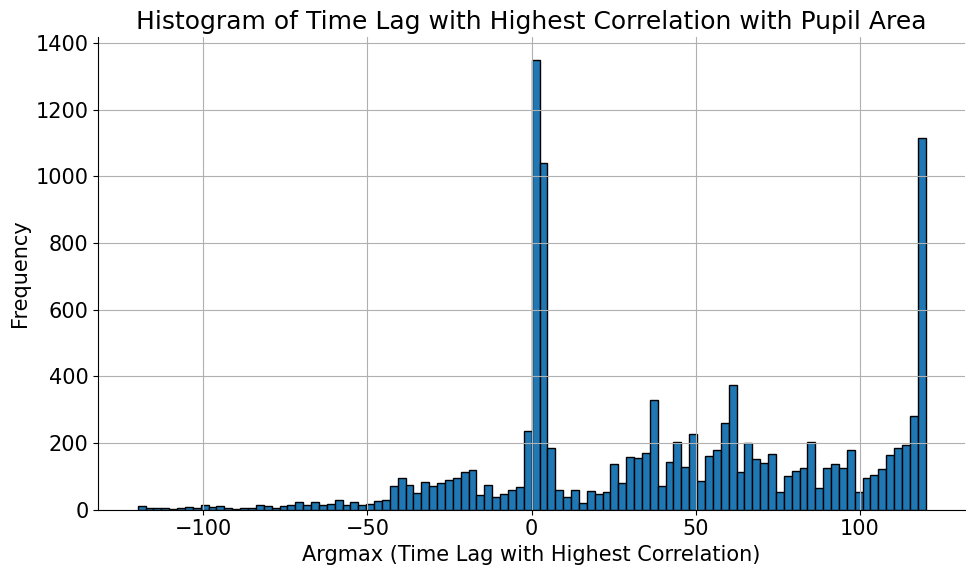

In [ ]:
# Create a histogram of argmax values
plt.figure(figsize=(10, 6))
plt.hist((argmax_cross_corr_pa-100)*1.2, bins=100, edgecolor='black')
plt.xlabel('Argmax (Time Lag with Highest Correlation)')
plt.ylabel('Frequency')
plt.title('Histogram of Time Lag with Highest Correlation with Pupil Area')
plt.grid(True)
plt.show()

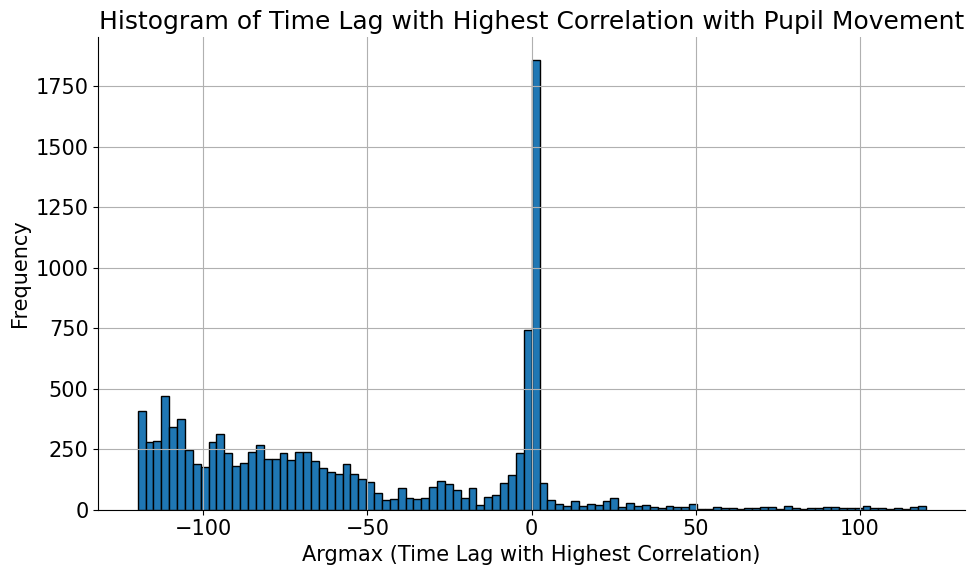

In [ ]:
# Create a histogram of argmax values
plt.figure(figsize=(10, 6))
plt.hist((argmax_cross_corr_pcom-100)*1.2, bins=100, edgecolor='black')
plt.xlabel('Argmax (Time Lag with Highest Correlation)')
plt.ylabel('Frequency')
plt.title('Histogram of Time Lag with Highest Correlation with Pupil Movement')
plt.grid(True)
plt.show()

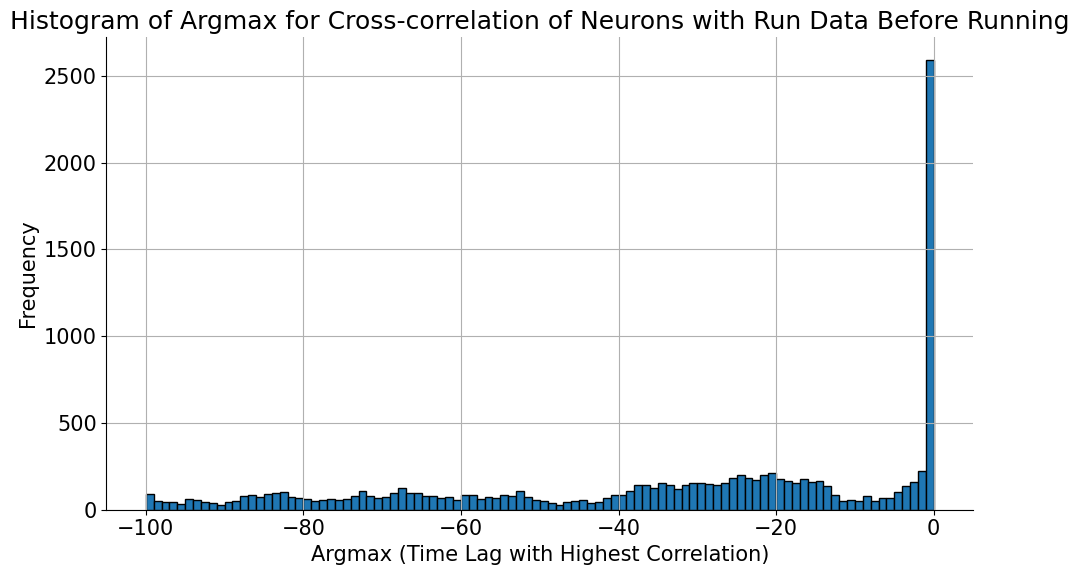

In [ ]:
# Create a histogram of argmax values
plt.figure(figsize=(10, 6))
plt.hist(argmax_cross_corr_bef - 100, bins=100, edgecolor='black')
plt.xlabel('Argmax (Time Lag with Highest Correlation)')
plt.ylabel('Frequency')
plt.title('Histogram of Argmax for Cross-correlation of Neurons with Run Data Before Running')
plt.grid(True)
plt.show()

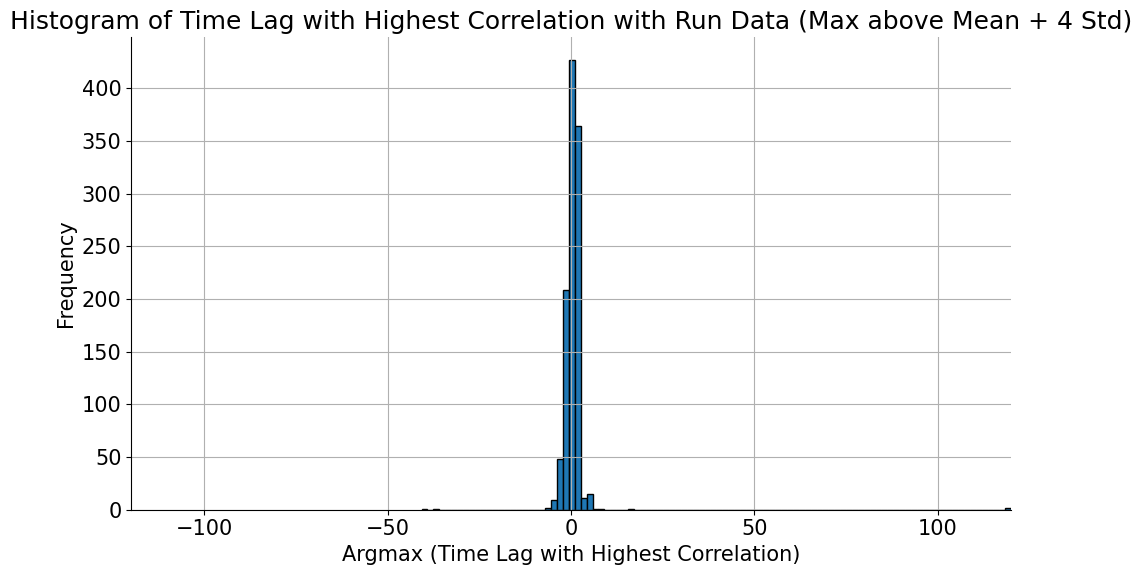

In [ ]:
# @title Histogram of TIme Lag with Highest Correlation Filtered by respective Mean and STD
# Filter argmax values where the maximum is above the mean two plus one standard deviation
filtered_argmax = argmax_cross_corr[max_cross_corr > (mean_cross_corr + 4*std_cross_corr)]

# Create a histogram of filtered argmax values
plt.figure(figsize=(10, 6))
plt.hist((filtered_argmax-100)*1.2, bins=100, edgecolor='black')
plt.xlabel('Argmax (Time Lag with Highest Correlation)')
plt.ylabel('Frequency')
plt.title('Histogram of Time Lag with Highest Correlation with Run Data (Max above Mean + 4 Std)')
plt.xlim(-120, 120)
plt.grid(True)
plt.show()

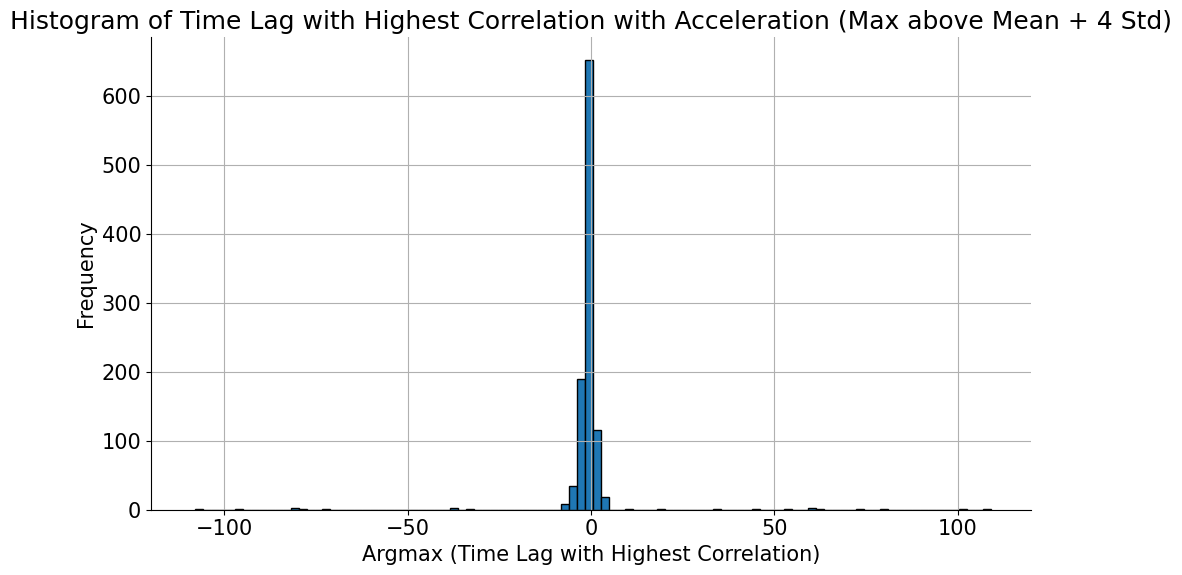

In [ ]:
# Filter argmax values where the maximum is above the mean two plus one standard deviation
filtered_argmax_acc = argmax_cross_corr_acc[max_cross_corr_acc > (mean_cross_corr_acc + 4*std_cross_corr_acc)]

# Create a histogram of filtered argmax values
plt.figure(figsize=(10, 6))
plt.hist((filtered_argmax_acc-100)*1.2, bins=100, edgecolor='black')
plt.xlabel('Argmax (Time Lag with Highest Correlation)')
plt.ylabel('Frequency')
plt.title('Histogram of Time Lag with Highest Correlation with Acceleration (Max above Mean + 4 Std)')
plt.xlim(-120, 120)
plt.grid(True)
plt.show()

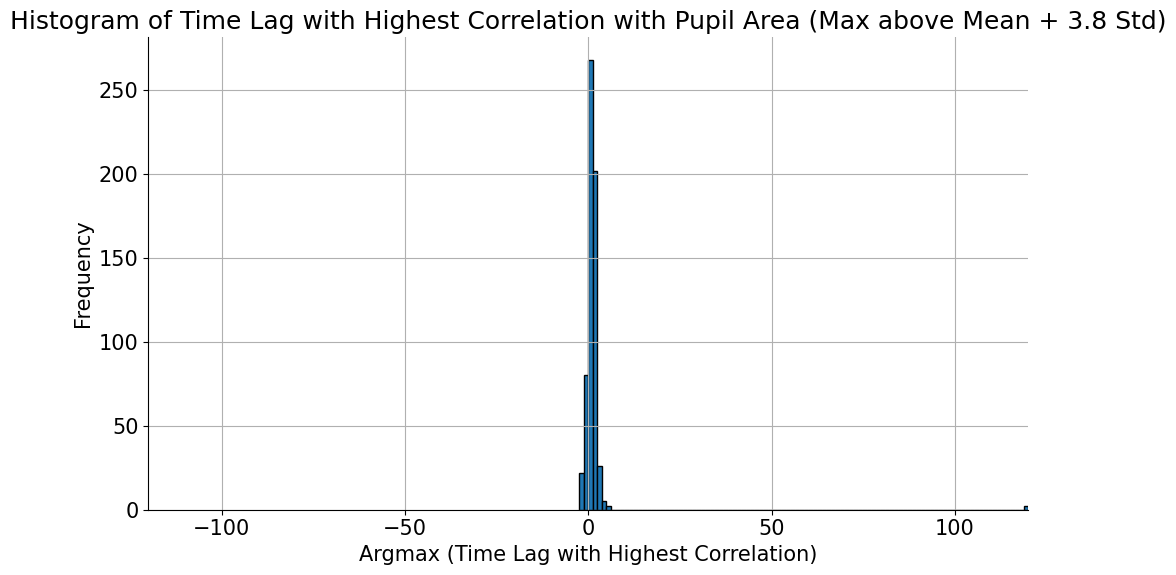

In [ ]:
# Filter argmax values where the maximum is above the mean two plus one standard deviation
filtered_argmax_pa = argmax_cross_corr_pa[max_cross_corr_pa > (mean_cross_corr_pa + 3.8*std_cross_corr_pa)]

# Create a histogram of filtered argmax values
plt.figure(figsize=(10, 6))
plt.hist((filtered_argmax_pa-100)*1.2, bins=100, edgecolor='black')
plt.xlabel('Argmax (Time Lag with Highest Correlation)')
plt.ylabel('Frequency')
plt.title('Histogram of Time Lag with Highest Correlation with Pupil Area (Max above Mean + 3.8 Std)')
plt.xlim(-120, 120)
plt.grid(True)
plt.show()

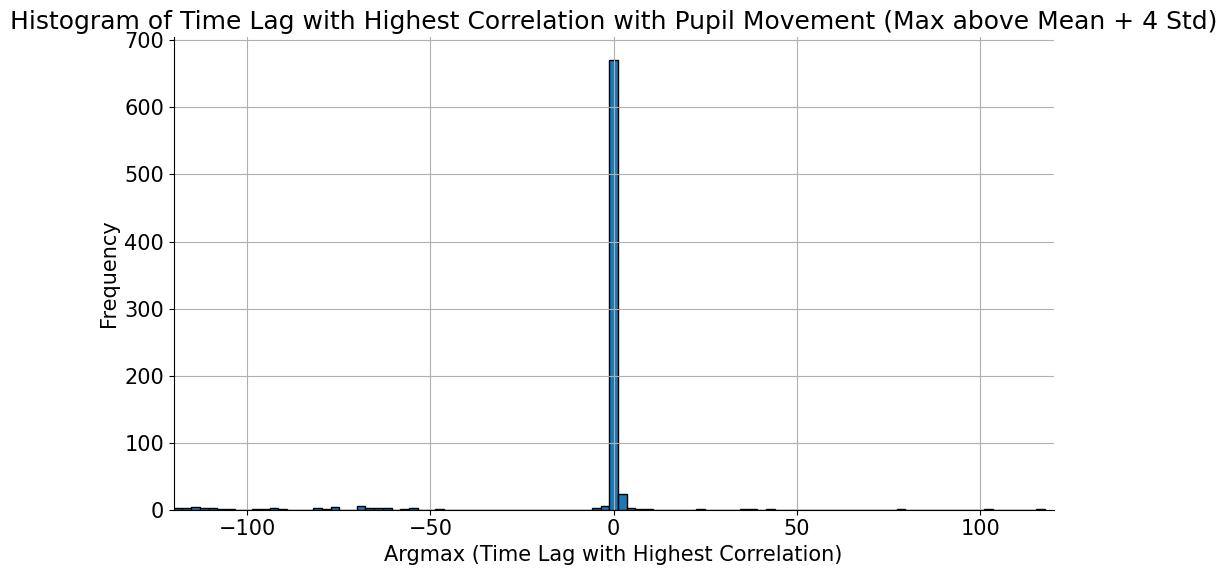

In [ ]:
# Filter argmax values where the maximum is above the mean two plus one standard deviation
filtered_argmax_pcom = argmax_cross_corr_pcom[max_cross_corr_pcom > (mean_cross_corr_pcom + 4*std_cross_corr_pcom)]

# Create a histogram of filtered argmax values
plt.figure(figsize=(10, 6))
plt.hist((filtered_argmax_pcom-100)*1.2, bins=100, edgecolor='black')
plt.xlabel('Argmax (Time Lag with Highest Correlation)')
plt.ylabel('Frequency')
plt.title('Histogram of Time Lag with Highest Correlation with Pupil Movement (Max above Mean + 4 Std)')
plt.xlim(-120, 120)
plt.grid(True)
plt.show()

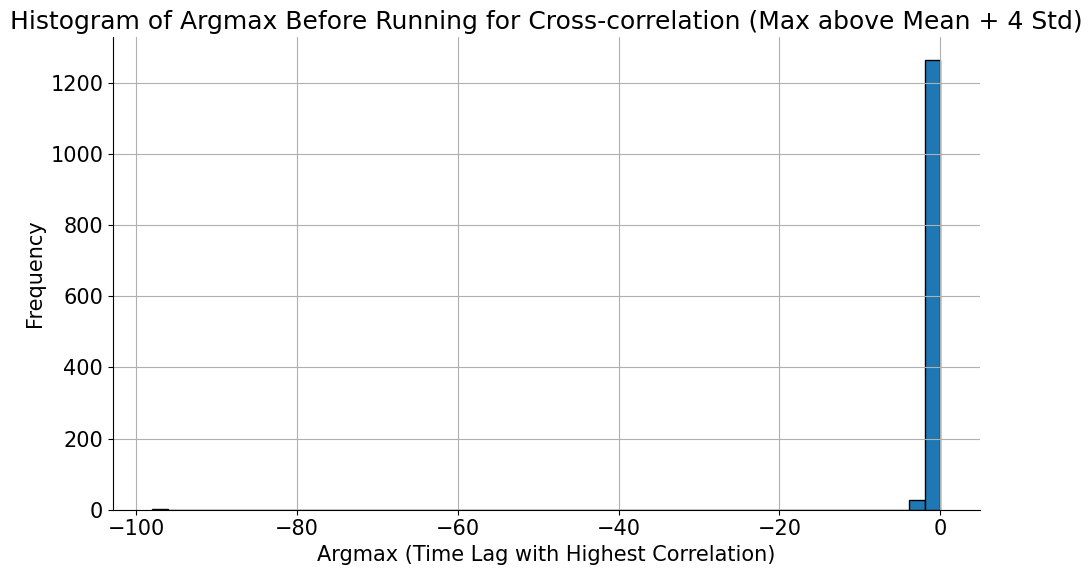

In [ ]:
# Filter argmax values where the maximum is above the mean two plus one standard deviation
filtered_argmax = argmax_cross_corr_bef[max_cross_corr_bef > (mean_cross_corr_bef + 4*std_cross_corr_bef)]

# Create a histogram of filtered argmax values
plt.figure(figsize=(10, 6))
plt.hist(filtered_argmax-100, bins= 50, edgecolor='black')
plt.xlabel('Argmax (Time Lag with Highest Correlation)')
plt.ylabel('Frequency')
plt.title('Histogram of Argmax Before Running for Cross-correlation (Max above Mean + 4 Std)')
plt.grid(True)
plt.show()

In [ ]:
# @title Using overall mean and std to filter neurons
# Flatten the cross-correlation array and calculate overall mean and std
flattened_cross_corr = cross_correlation_results.flatten()
overall_mean_cross_corr = np.mean(flattened_cross_corr)
overall_std_cross_corr = np.std(flattened_cross_corr)

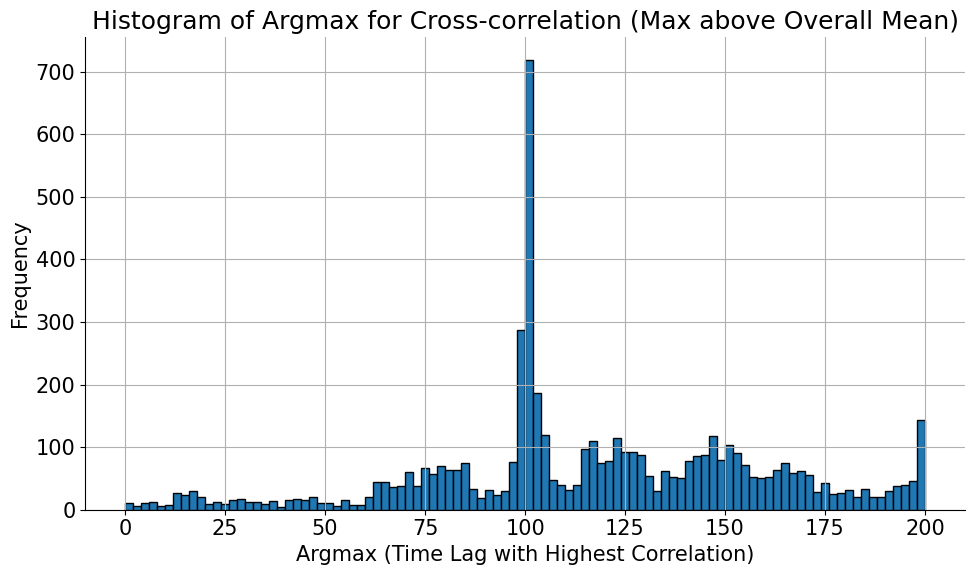

In [ ]:
# Filter argmax values where the maximum is above the mean two plus one standard deviation
filtered_argmax = argmax_cross_corr[max_cross_corr > overall_mean_cross_corr]

# Create a histogram of filtered argmax values
plt.figure(figsize=(10, 6))
plt.hist((filtered_argmax-100)*1.2, bins=100, edgecolor='black')
plt.xlabel('Argmax (Time Lag with Highest Correlation)')
plt.ylabel('Frequency')
plt.title('Histogram of Argmax for Cross-correlation (Max above Overall Mean)')
plt.grid(True)
plt.show()

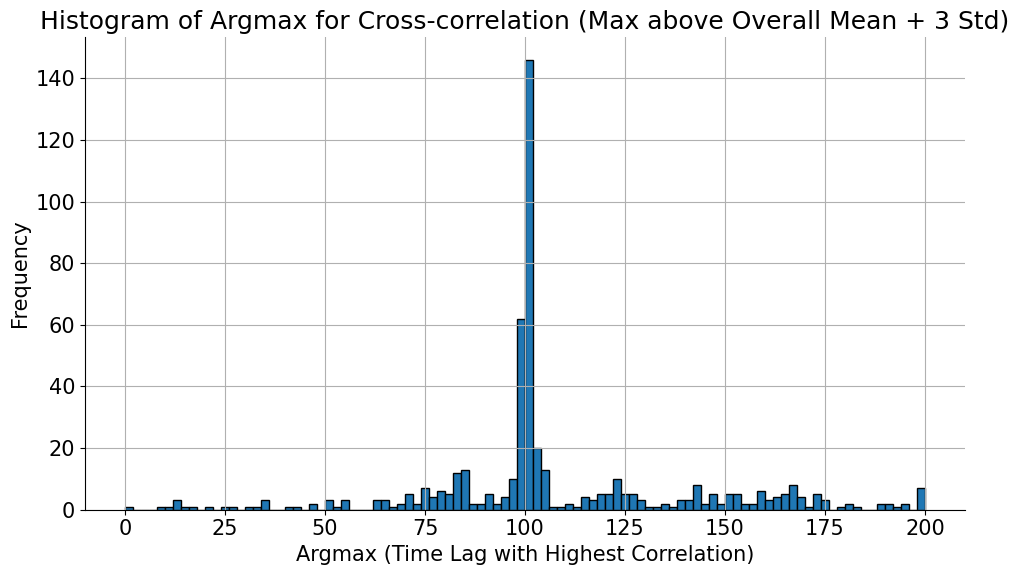

In [ ]:
# Filter argmax values where the maximum is above the mean two plus one standard deviation
filtered_argmax = argmax_cross_corr[max_cross_corr > overall_mean_cross_corr + 3 * overall_std_cross_corr]

# Create a histogram of filtered argmax values
plt.figure(figsize=(10, 6))
plt.hist(filtered_argmax, bins=100, edgecolor='black')
plt.xlabel('Argmax (Time Lag with Highest Correlation)')
plt.ylabel('Frequency')
plt.title('Histogram of Argmax for Cross-correlation (Max above Overall Mean + 3 Std)')
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import pearsonr

# Calculate correlation coefficient and p-value for each neuron
correlation_coefficients = []
p_values = []

for neuron_idx, lag in enumerate(argmax_cross_corr):
    neuron_corr, neuron_p_value = pearsonr(sresp_data[neuron_idx, 100:-100], run_data[lag : len(run_data)-(200 - lag), 0])
    correlation_coefficients.append(neuron_corr)
    p_values.append(neuron_p_value)

In [ ]:
correlation_coefficients = np.array(correlation_coefficients)
p_values = np.array(p_values)

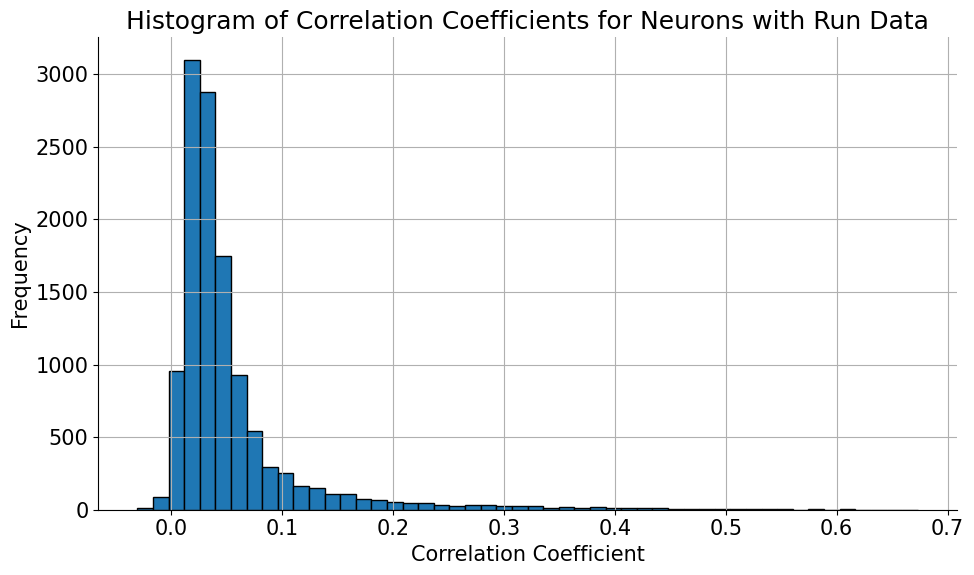

In [ ]:
# Create a histogram of correlation coefficients
plt.figure(figsize=(10, 6))
plt.hist(correlation_coefficients, bins=50, edgecolor='black')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of Correlation Coefficients for Neurons with Run Data')
plt.grid(True)
plt.show()

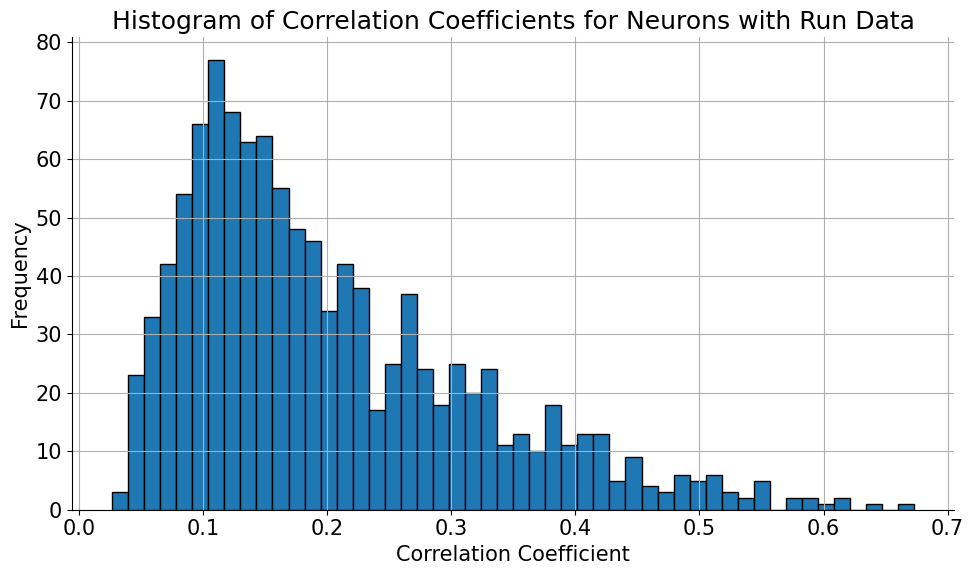

In [ ]:
# Create a histogram of correlation coefficients
plt.figure(figsize=(10, 6))
plt.hist(correlation_coefficients[max_cross_corr > (mean_cross_corr + 4*std_cross_corr)], bins=50, edgecolor='black')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of Correlation Coefficients for Neurons with Run Data')
plt.grid(True)
plt.show()

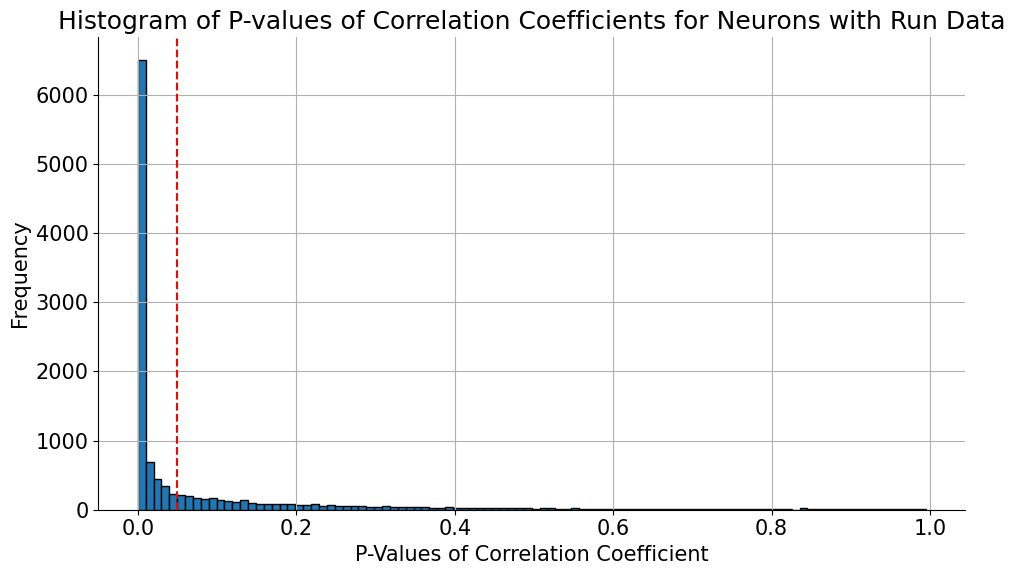

In [ ]:
# Create a histogram of p-values correlation coefficients
plt.figure(figsize=(10, 6))
plt.hist(p_values, bins=100, edgecolor='black')
plt.xlabel('P-Values of Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of P-values of Correlation Coefficients for Neurons with Run Data')
plt.axvline(x=0.05, color='red', linestyle='--', label="Vertical Line at x=0.05")
plt.grid(True)
plt.show()

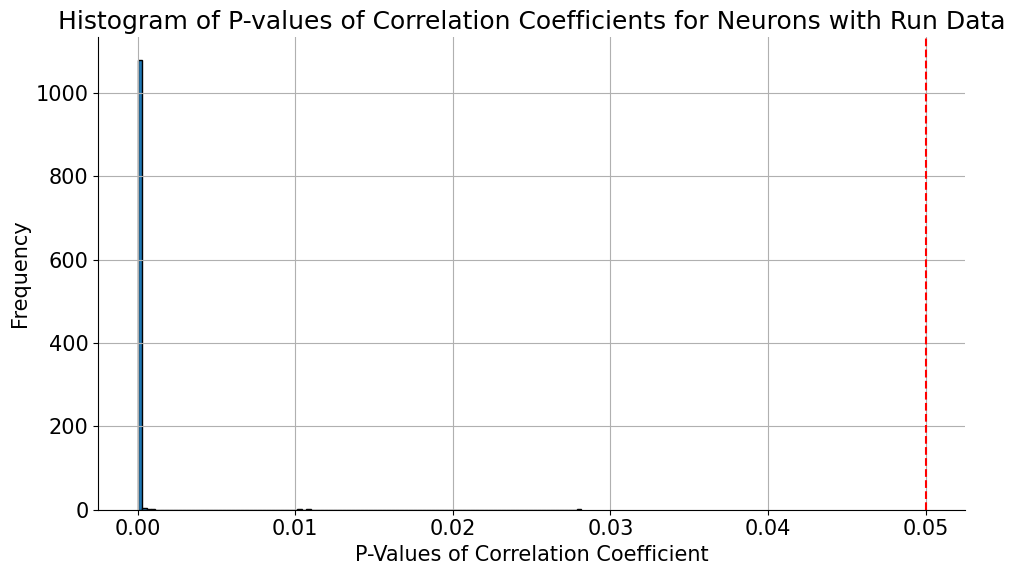

In [ ]:
# Create a histogram of p-values correlation coefficients
plt.figure(figsize=(10, 6))
plt.hist(p_values[max_cross_corr > (mean_cross_corr + 4*std_cross_corr)], bins=100, edgecolor='black')
plt.xlabel('P-Values of Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of P-values of Correlation Coefficients for Neurons with Run Data')
plt.axvline(x=0.05, color='red', linestyle='--', label="Vertical Line at x=0.05")
plt.grid(True)
plt.show()

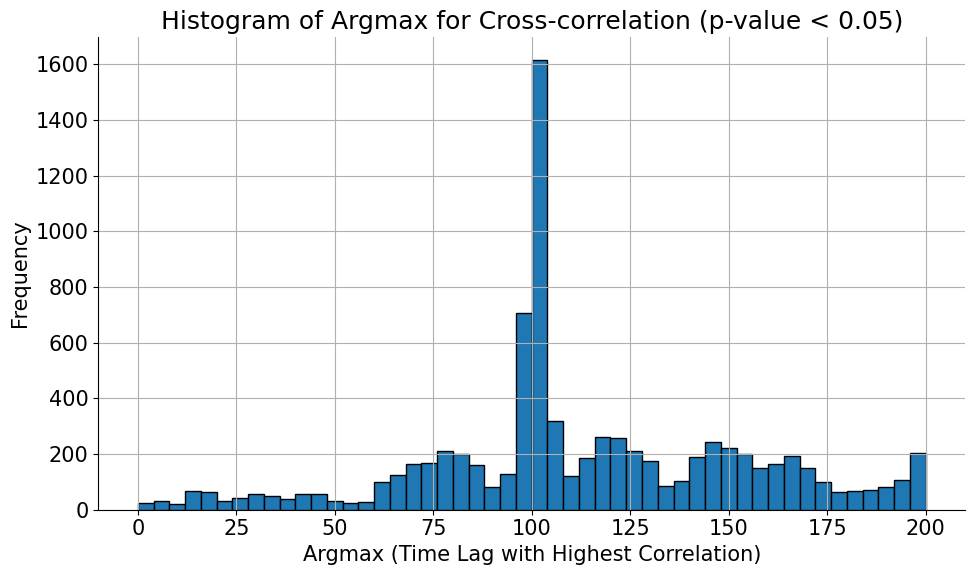

In [ ]:
# Filter argmax values where the p-value is below 0.05
filtered_argmax = argmax_cross_corr[np.array(p_values) < 0.05]

# Create a histogram of filtered argmax values
plt.figure(figsize=(10, 6))
plt.hist(filtered_argmax, bins=50, edgecolor='black')
plt.xlabel('Argmax (Time Lag with Highest Correlation)')
plt.ylabel('Frequency')
plt.title('Histogram of Argmax for Cross-correlation (p-value < 0.05)')
plt.grid(True)
plt.show()

In [ ]:
sum(np.array(p_values) < 0.05) / len(sresp_data)

0.686055244930318

In [ ]:
# @title Correlation Coefficient for Negative Time Lag
from scipy.stats import pearsonr

# Calculate correlation coefficient and p-value for each neuron
correlation_coefficients_bef = []
p_values_bef = []

for neuron_idx, lag in enumerate(argmax_cross_corr_bef):
    neuron_corr, neuron_p_value = pearsonr(sresp_data[neuron_idx, 100:-100], run_data[lag : len(run_data)-(200 - lag), 0])
    correlation_coefficients_bef.append(neuron_corr)
    p_values_bef.append(neuron_p_value)

In [ ]:
correlation_coefficients_bef = np.array(correlation_coefficients_bef)
p_values_bef = np.array(p_values_bef)

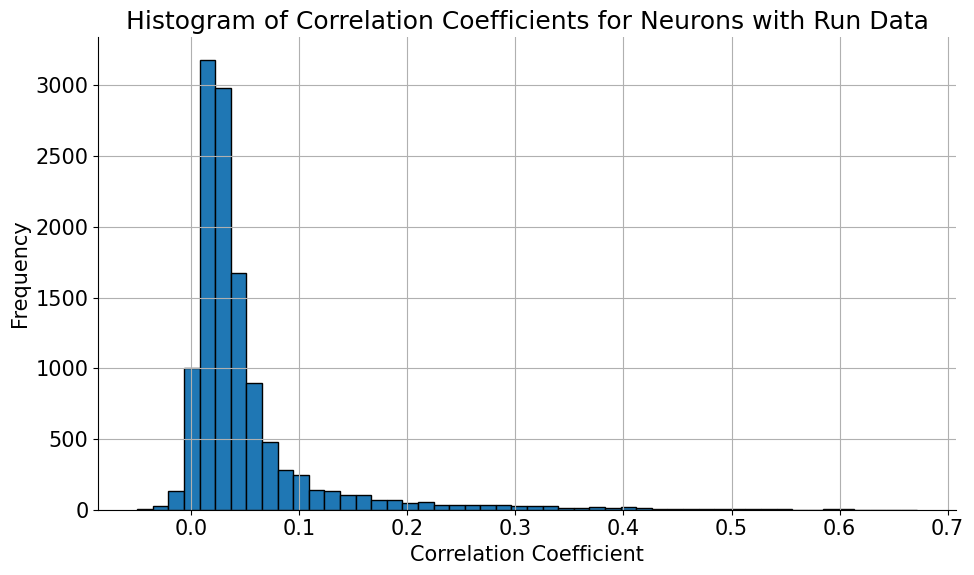

In [ ]:
# Create a histogram of correlation coefficients
plt.figure(figsize=(10, 6))
plt.hist(correlation_coefficients_bef, bins=50, edgecolor='black')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of Correlation Coefficients for Neurons with Run Data')
plt.grid(True)
plt.show()

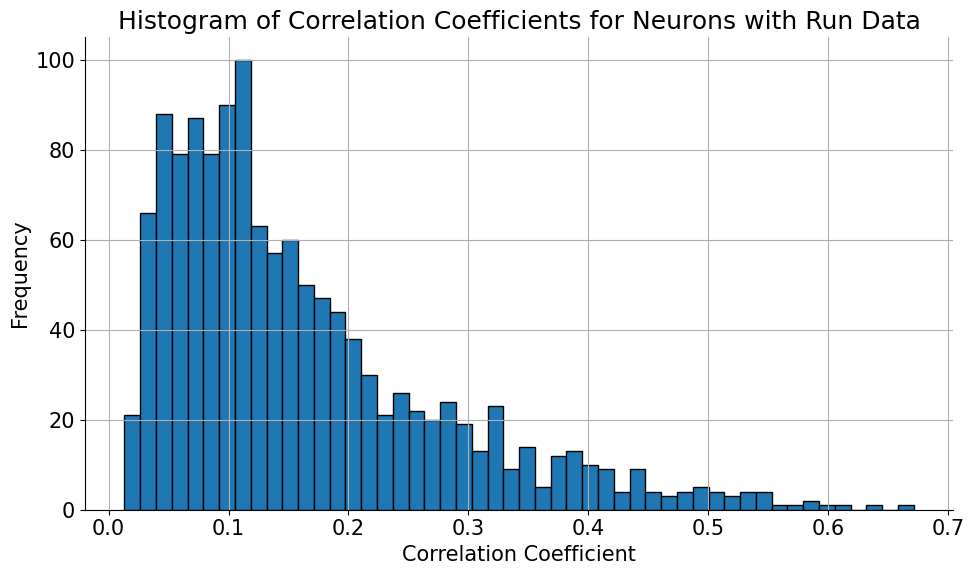

In [ ]:
# Create a histogram of correlation coefficients
plt.figure(figsize=(10, 6))
plt.hist(correlation_coefficients_bef[max_cross_corr_bef > (mean_cross_corr_bef + 4*std_cross_corr_bef)], bins=50, edgecolor='black')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of Correlation Coefficients for Neurons with Run Data')
plt.grid(True)
plt.show()

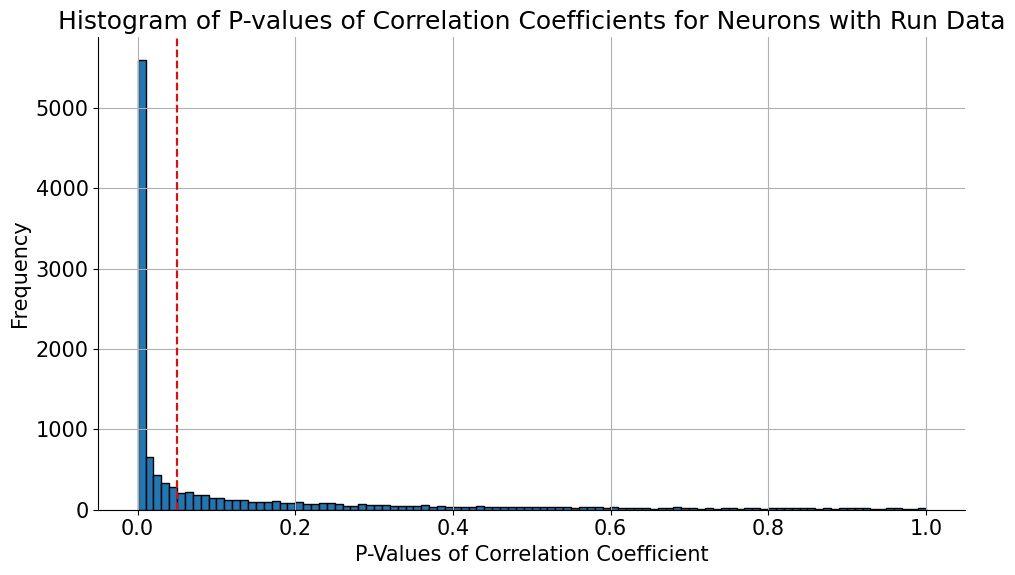

In [ ]:
# Create a histogram of p-values correlation coefficients
plt.figure(figsize=(10, 6))
plt.hist(p_values_bef, bins=100, edgecolor='black')
plt.xlabel('P-Values of Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of P-values of Correlation Coefficients for Neurons with Run Data')
plt.axvline(x=0.05, color='red', linestyle='--', label="Vertical Line at x=0.05")
plt.grid(True)
plt.show()

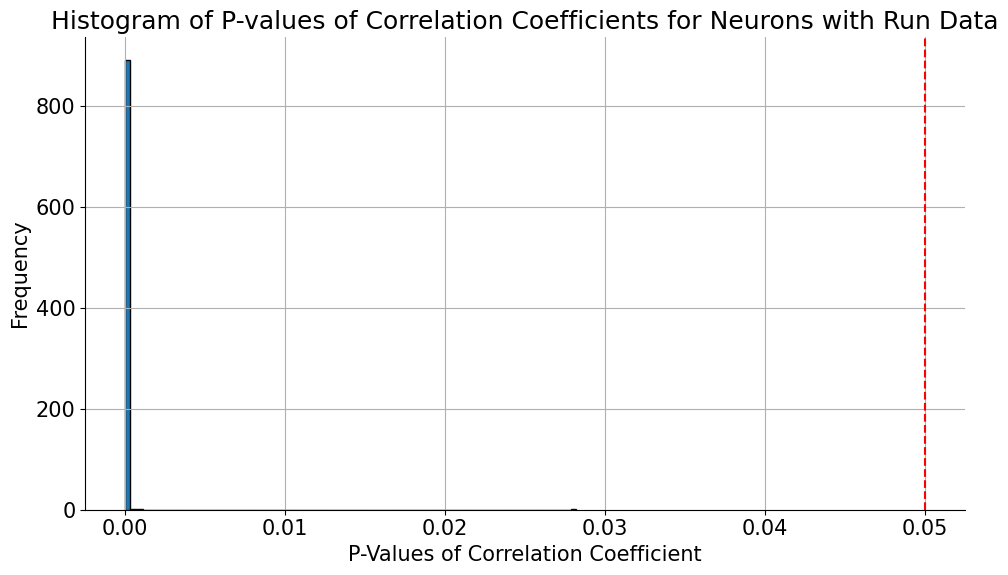

In [ ]:
# Create a histogram of p-values correlation coefficients
plt.figure(figsize=(10, 6))
plt.hist(p_values_bef[max_cross_corr_bef > (mean_cross_corr + 4*std_cross_corr)], bins=100, edgecolor='black')
plt.xlabel('P-Values of Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of P-values of Correlation Coefficients for Neurons with Run Data')
plt.axvline(x=0.05, color='red', linestyle='--', label="Vertical Line at x=0.05")
plt.grid(True)
plt.show()

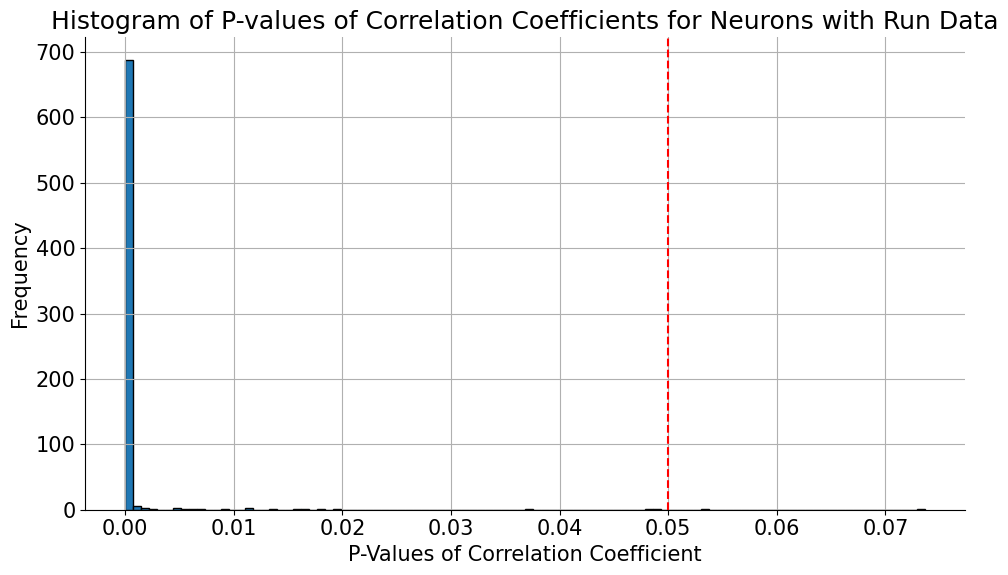

In [ ]:
# Create a histogram of p-values correlation coefficients
plt.figure(figsize=(10, 6))
plt.hist(p_values_bef[max_cross_corr_bef > (mean_cross_corr_bef + 4.5*std_cross_corr_bef)], bins=100, edgecolor='black')
plt.xlabel('P-Values of Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of P-values of Correlation Coefficients for Neurons with Run Data')
plt.axvline(x=0.05, color='red', linestyle='--', label="Vertical Line at x=0.05")
plt.grid(True)
plt.show()

In [ ]:
print("Highly correlated Neurons Count:", np.sum(max_cross_corr > (mean_cross_corr + 4*std_cross_corr)))
print("Highly correlated Neurons with Negative Time Lag Count:", np.sum(max_cross_corr_bef > (mean_cross_corr + 4*std_cross_corr)))
print("Highly correlated Neurons with Negative Time Lag Count Using mean and std from neg time lag:", np.sum(max_cross_corr_bef > (mean_cross_corr_bef + 4.5*std_cross_corr_bef)))

Highly correlated Neurons Count: 1092
Highly correlated Neurons with Negative Time Lag Count: 897
Highly correlated Neurons with Negative Time Lag Count Using mean and std from neg time lag: 715


In [ ]:
argmax_cross_corr_bef[max_cross_corr_bef > (mean_cross_corr + 4*std_cross_corr)][:200]

array([100, 100,  96, 100, 100,  99, 100, 100,  97,  99, 100, 100, 100,
        99, 100, 100, 100,  99,  99, 100,  99, 100, 100,  99,  98,  99,
        99,  99, 100, 100,  99,  98, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100,  99,  99, 100, 100,  99,  99, 100,
        99, 100, 100, 100, 100, 100,  99, 100,  98, 100, 100,  99,  99,
       100, 100, 100, 100, 100, 100,  99, 100, 100, 100, 100, 100, 100,
        99, 100,  99, 100, 100,  95,  97, 100,  99,  99,  99,  99, 100,
        99, 100,  99,  99, 100,  99, 100,  99, 100,  99, 100, 100,  96,
       100, 100,  99, 100, 100,  98, 100, 100,  99, 100, 100, 100,  98,
       100,  98,  99, 100, 100, 100, 100,  99, 100, 100, 100, 100, 100,
       100, 100, 100,  99, 100, 100, 100,  99,  99, 100, 100,  99, 100,
       100,  99,  99, 100, 100, 100, 100, 100, 100,  99,  99, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        99, 100, 100, 100,  98,  99, 100, 100, 100, 100, 100,  9

<ipython-input-48-4b0f03a5d3b8>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


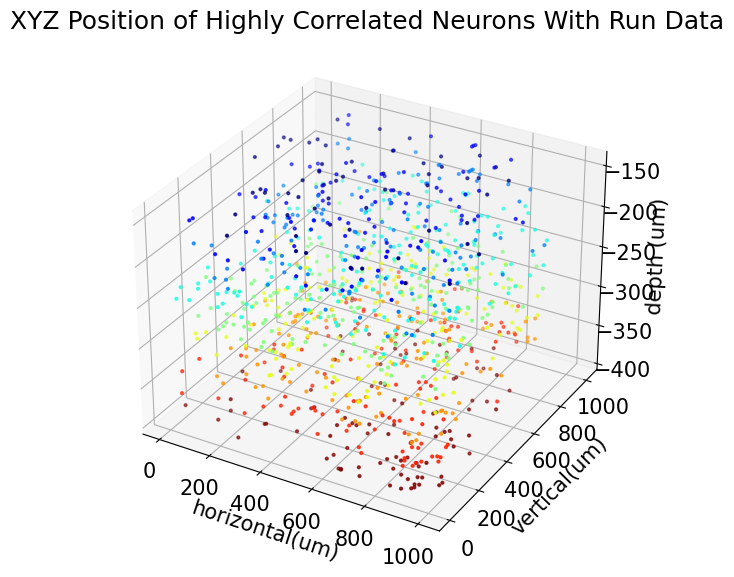

In [ ]:
# @title Plot the 3D Positions of Neurons Correlated with Run Data
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz'][:, max_cross_corr > (mean_cross_corr + 4*std_cross_corr)]

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.title('XYZ Position of Highly Correlated Neurons With Run Data')
plt.show()

<ipython-input-56-3706da68c026>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')


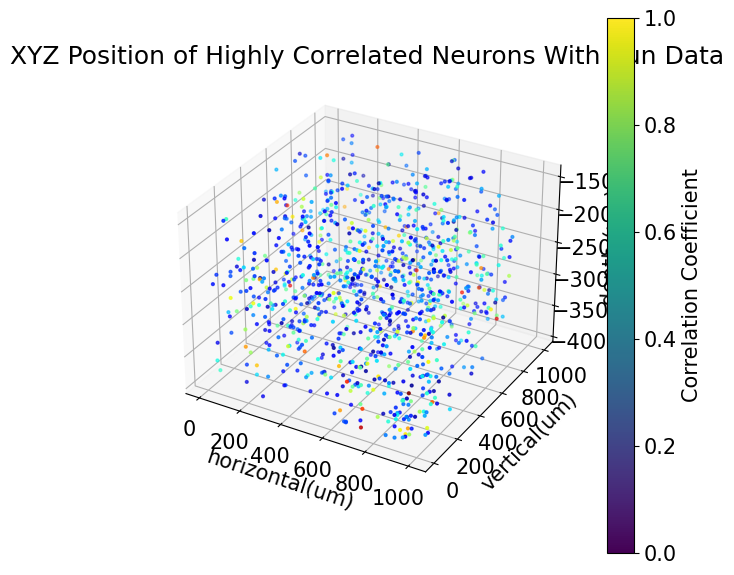

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# filter indices
filter_indices = max_cross_corr > (mean_cross_corr + 4*std_cross_corr)

# get the filtered xyz coordinates and correlation coefficients
x, y, z = dat['xyz'][:, filter_indices]
correlation_filtered = correlation_coefficients[filter_indices]

# normalize correlation coefficients to be between 0 and 1
correlation_filtered_normalized = (correlation_filtered - correlation_filtered.min()) / (correlation_filtered.max() - correlation_filtered.min())

# use the normalized correlation coefficients to get color values
cmap = cm.get_cmap('jet')
colors = cmap(correlation_filtered_normalized)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x[::-1], y[::-1], z[::-1], 'o', s=4, c=colors)

# add colorbar
plt.colorbar(sc, label='Correlation Coefficient')

ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.title('XYZ Position of Highly Correlated Neurons With Run Data')
plt.show()


<ipython-input-52-ea61be3fea9d>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


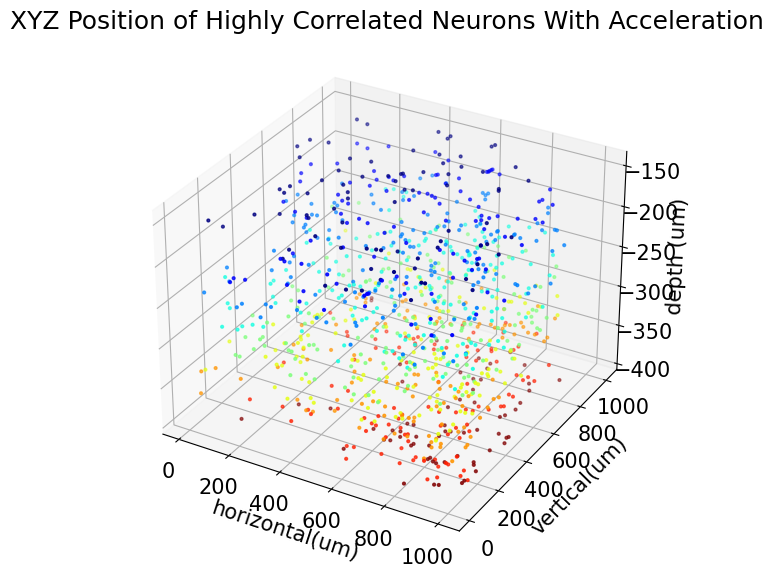

In [ ]:
# @title Plot the 3D Positions of Neurons Correlated with Acceleration
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz'][:, max_cross_corr_acc > (mean_cross_corr_acc + 4*std_cross_corr_acc)]

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.title('XYZ Position of Highly Correlated Neurons With Acceleration')
plt.show()

<ipython-input-49-b5fcef077f82>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


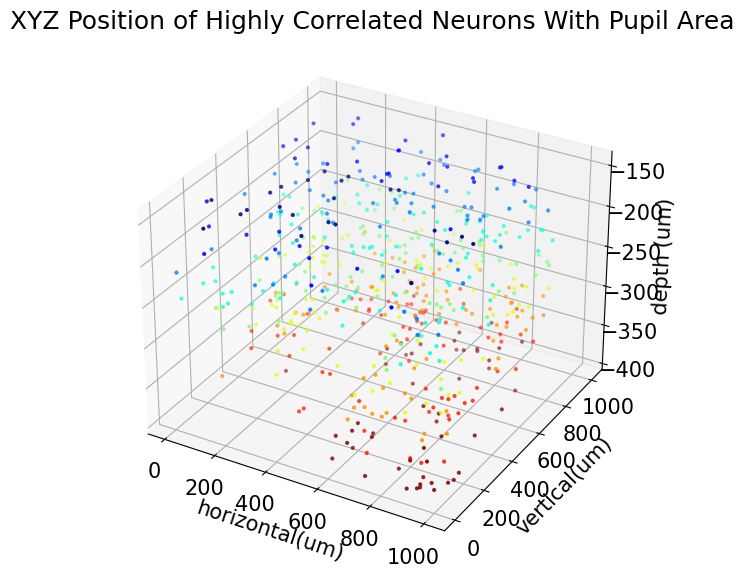

In [ ]:
# @title Plot the 3D Positions of Neurons Correlated with Pupil Area
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz'][:, max_cross_corr_pa > (mean_cross_corr_pa + 3.8*std_cross_corr_pa)]

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.title('XYZ Position of Highly Correlated Neurons With Pupil Area')
plt.show()

<ipython-input-50-707337d9b517>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


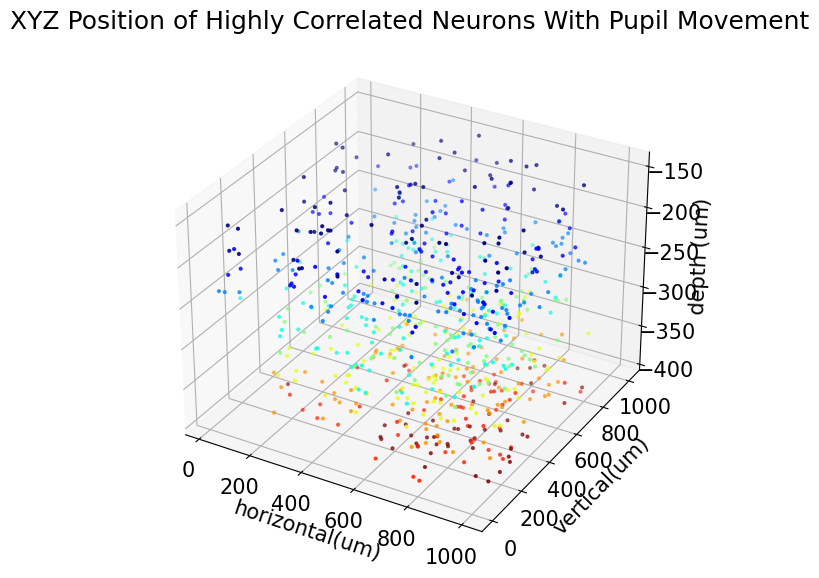

In [ ]:
# @title Plot the 3D Positions of Neurons Correlated with Pupil Movement
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz'][:, max_cross_corr_pcom > (mean_cross_corr_pcom + 4*std_cross_corr_pcom)]

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.title('XYZ Position of Highly Correlated Neurons With Pupil Movement')
plt.show()

In [ ]:
# @title Predict Velocity Using Neural Response Data

import tensorflow as tf
from sklearn.model_selection import train_test_split

# Step 1: Data Preprocessing

# Step 2: Divide the Data
# Assuming dat['sresp'] and dat['run'] are NumPy arrays
X = dat['sresp'].T # Neural response data
y = dat['run']     # Running speed data

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Build and Train the Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with 1 neuron for velocity prediction
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Step 4: Validate the Model
# Evaluate the model on the testing set
loss = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", loss)


Epoch 1/10
176/176 [==============================] - 4s 14ms/step - loss: 2430.5029
Epoch 2/10
176/176 [==============================] - 2s 12ms/step - loss: 429.2420
Epoch 3/10
176/176 [==============================] - 3s 16ms/step - loss: 206.5209
Epoch 4/10
176/176 [==============================] - 4s 22ms/step - loss: 193.5447
Epoch 5/10
176/176 [==============================] - 5s 28ms/step - loss: 263.1664
Epoch 6/10
176/176 [==============================] - 2s 12ms/step - loss: 223.1113
Epoch 7/10
176/176 [==============================] - 2s 12ms/step - loss: 180.8413
Epoch 8/10
176/176 [==============================] - 2s 12ms/step - loss: 96.5938
Epoch 9/10
176/176 [==============================] - 2s 12ms/step - loss: 64.7388
Epoch 10/10
44/44 [==============================] - 0s 4ms/step - loss: 149.6776
Mean Squared Error on Testing Set: 149.6776123046875


44/44 [==============================] - 0s 3ms/step


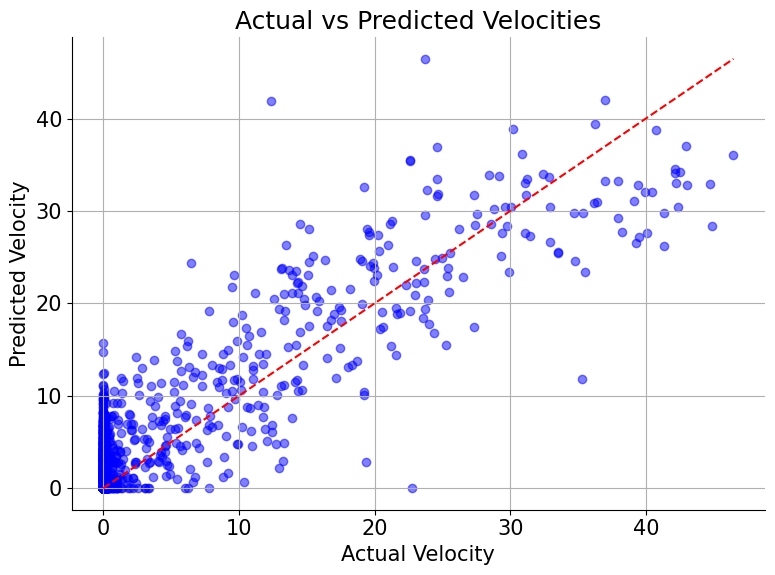

In [ ]:
# Predict the velocities using the trained model on the testing set
y_pred = model.predict(X_test).flatten()
y_pred = np.maximum(y_pred, 0)

# Step 5: Plot Actual vs Predicted Velocities
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='b', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.xlabel('Actual Velocity')
plt.ylabel('Predicted Velocity')
plt.title('Actual vs Predicted Velocities')
plt.grid(True)
plt.show()

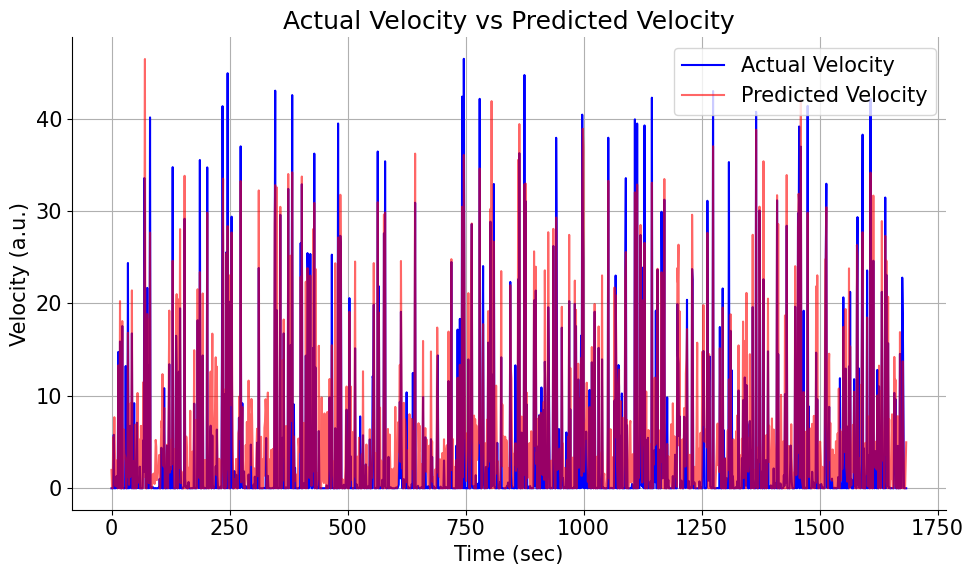

In [ ]:
# Plot actual velocity vs predicted velocity across time
timebins = np.arange(y_test.shape[0]) * 1.2  # Assuming timebin = 1.2 sec
plt.figure(figsize=(10, 6))
plt.plot(timebins, y_test, label='Actual Velocity', color='blue', alpha = 1)
plt.plot(timebins, y_pred, label='Predicted Velocity', color='red', alpha = 0.6)
plt.xlabel('Time (sec)')
plt.ylabel('Velocity (a.u.)')
plt.title('Actual Velocity vs Predicted Velocity')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Data Preprocessing

# Step 2: Create Sequences with the Last 5 Timesteps
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Assuming dat['sresp'] is the 2D array of neural response data (neurons by timebins)
seq_length = 5  # Number of timesteps in each sequence
X_sequences = create_sequences(dat['sresp'], seq_length)
X_sequences = X_sequences.transpose((2, 0, 1))

# Assuming dat['run'] is the 1D array of running speed data
y = dat['run']  # Exclude the first (seq_length - 1) velocity data points

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y, test_size=0.2, random_state=42)

# Step 3: Build and Train the LSTM RNN
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with 1 neuron for velocity prediction
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Step 4: Validate the Model and Plot Results
# Evaluate the model on the testing set
loss = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", loss)

# Use the trained model to make predictions on the testing set
y_pred = model.predict(X_test)

# Plot actual velocity vs predicted velocity across time
timebins = np.arange(y_test.shape[0]) * 1.2  # Assuming timebin = 1.2 sec
plt.figure(figsize=(10, 6))
plt.plot(timebins, y_test, label='Actual Velocity', color='blue')
plt.plot(timebins, y_pred, label='Predicted Velocity', color='red')
plt.xlabel('Time (sec)')
plt.ylabel('Velocity (a.u.)')
plt.title('Actual Velocity vs Predicted Velocity')
plt.legend()
plt.grid(True)
plt.show()


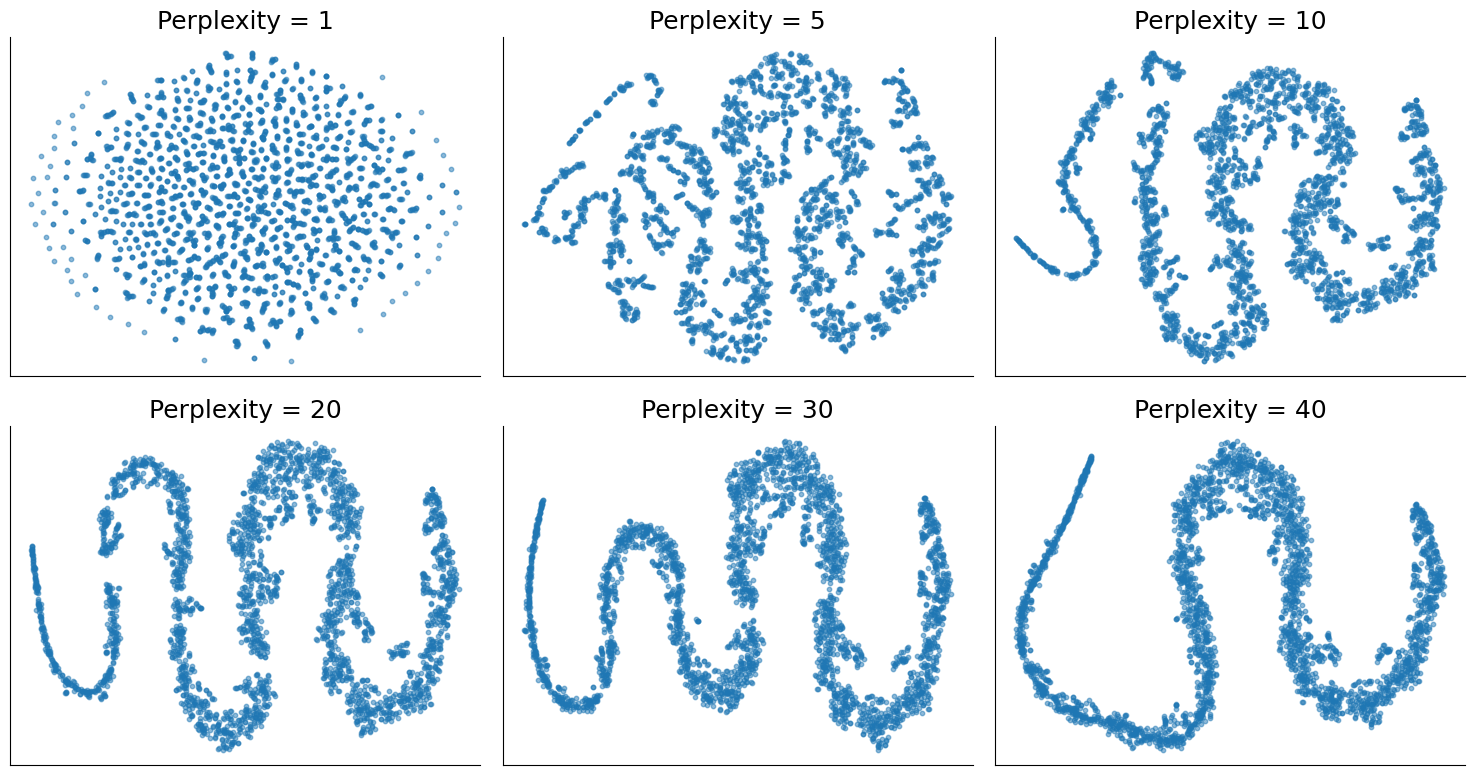

In [ ]:
# @title Apply T-SNE
from sklearn.manifold import TSNE

# Randomly select 25% of neurons
num_neurons = cross_correlation_results.shape[0]
num_neurons_25percent = int(num_neurons * 0.25)
random_indices = np.random.choice(num_neurons, num_neurons_25percent, replace=False)
selected_cross_correlation_results = cross_correlation_results[random_indices]

# List of perplexity values to try (up to 50)
perplexities = [1, 5, 10, 20, 30, 40]

# Create subplots for each t-SNE embedding
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, perplexity in enumerate(perplexities):
    # Applying t-SNE to the cross-correlation results
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    embedded_results = tsne.fit_transform(selected_cross_correlation_results)

    # Create a scatter plot of the t-SNE embeddings
    axes[i].scatter(embedded_results[:, 0], embedded_results[:, 1], s=10, alpha=0.5)
    axes[i].set_title(f'Perplexity = {perplexity}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

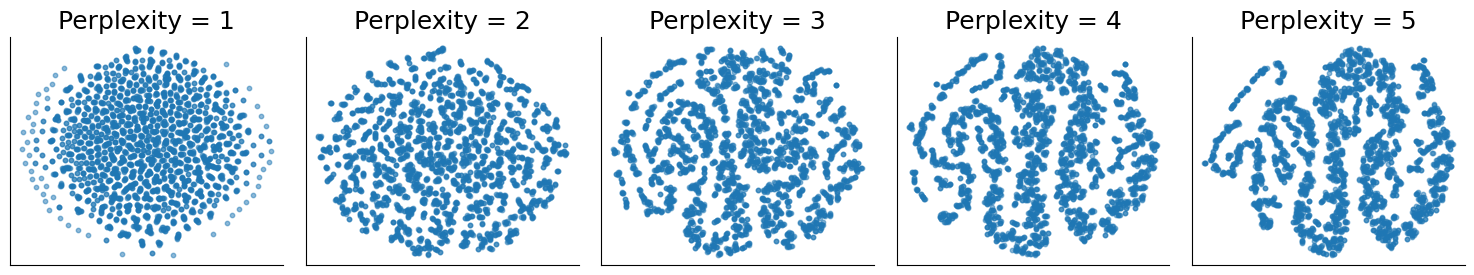

In [ ]:
# Range of perplexity values to try
perplexities = range(1,6)

# Create subplots for each t-SNE embedding
num_plots = len(perplexities)
rows = int(np.ceil(num_plots / 5))
fig, axes = plt.subplots(rows, 5, figsize=(15, 3 * rows))
axes = axes.ravel()

for i, perplexity in enumerate(perplexities):
    # Applying t-SNE to the cross-correlation results with the current perplexity
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    embedded_results = tsne.fit_transform(selected_cross_correlation_results)

    # Create a scatter plot of the t-SNE embeddings
    axes[i].scatter(embedded_results[:, 0], embedded_results[:, 1], s=10, alpha=0.5)
    axes[i].set_title(f'Perplexity = {perplexity}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Hide any empty subplots
for i in range(num_plots, rows * 5):
    fig.delaxes(axes[i])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [ ]:
cross_correlate_max_check = []

for neuron_idx, lag in enumerate(argmax_cross_corr):
    cross_correlate_max_check.append(np.sum(sresp_data[neuron_idx, 100:-100] * run_data[lag : len(run_data)-(200 - lag), 0]))

cross_correlate_max_check = np.array(cross_correlate_max_check)

In [ ]:
cross_correlate_max_check

array([ 217045.99825034,  150045.46208943,  131259.20477169, ...,
        946723.91887127, 1526701.53382308,   79432.6766555 ])

In [ ]:
max_cross_corr

array([ 217045.99825034,  150045.46208943,  131259.20477169, ...,
        946723.91887127, 1526701.53382308,   79432.6766555 ])